## Tweet Emotion Recognition: NLP with TensorFlow

## Introduction

Welcome to this Jupyter notebook on **tweet emotion recognition** using the **Emotions dataset for NLP** from **Kaggle**. In this notebook, I will explore a dataset of tweets labeled with one of seven emotions: anger, fear, joy, love, sadness and surprise.

The Emotions dataset for NLP is a great resource for anyone interested in building a model for emotion recognition in tweets. It provides a large and diverse set of tweets labeled with their corresponding emotions, making it an ideal dataset for training and testing NLP models.



## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
%pip install nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.17.0


## Importing and Undestanding the Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples
4. Getting an overview of the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# data = nlp.load_dataset('emotion') : connectionerror: couldn't reach https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1
#didn't work! see more : https://github.com/dair-ai/emotion_dataset/issues/5
#so I'll be using https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
import pandas as pd

train = pd.read_csv(
    '/content/drive/MyDrive/archive/train.txt',
    sep=";",
    names=["text","label"])

val = pd.read_csv(
    '/content/drive/MyDrive/archive/val.txt',
    sep=";",
    names=["text","label"])

test = pd.read_csv(
    '/content/drive/MyDrive/archive/test.txt',
    sep=";",
    names=["text","label"])

In [ ]:
train.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [7]:
def get_tweet(data):
    tweets = data["text"]
    labels = data["label"]
    return tweets, labels

In [8]:
tweets, labels = get_tweet(train)
print(tweets[50]," : ", labels[50])

i need to feel the dough to make sure its just perfect  :  joy


In [9]:
def data_description(data):
    shape = data.shape
    text_nulls = data["text"].isnull().sum()
    label_nulls = data["label"].isnull().sum()
    label_count = data["label"].value_counts()

    plt.hist(data["label"])
    plt.xlabel('emotions')
    plt.ylabel('Frequency')
    plt.title('data distribution')

    print("data shape : ",shape)
    print("null values in text field : ", text_nulls)
    print("null values in text field : ", label_nulls)
    print("label counts")
    print(label_count)
    plt.show()

Training data description
data shape :  (16000, 2)
null values in text field :  0
null values in text field :  0
label counts
label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


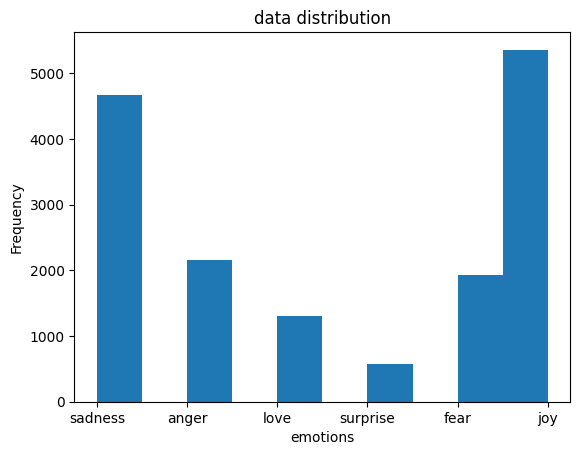

In [10]:
print("Training data description")
data_description(train)

Test data description
data shape :  (2000, 2)
null values in text field :  0
null values in text field :  0
label counts
label
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


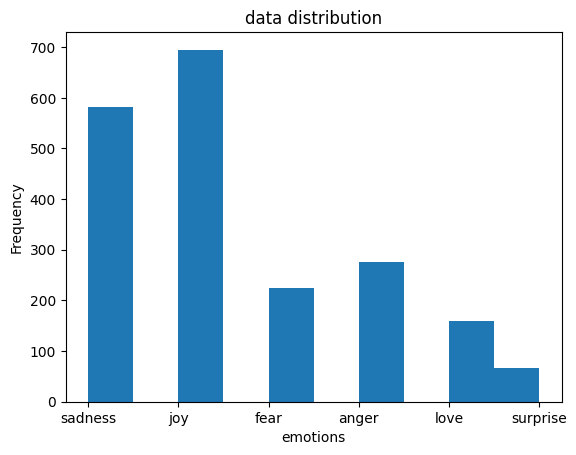

In [11]:
print("Test data description")
data_description(test)

Validation data description
data shape :  (2000, 2)
null values in text field :  0
null values in text field :  0
label counts
label
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64


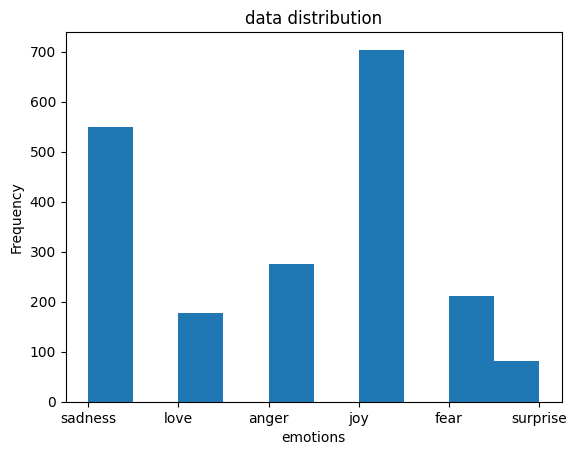

In [12]:
print("Validation data description")
data_description(val)

## Tokenization

Tokenization is the process of breaking down a string of text into smaller pieces, called tokens. These tokens can be words, phrases, or symbols. Tokenization is a common step in natural language processing (NLP) tasks, such as text classification, sentiment analysis, and machine translation.

The `Tokenizer` class in the `tensorflow.keras.preprocessing.text` module in TensorFlow provides a convenient way to perform tokenization on text data. The class can be used to tokenize text into words or characters, and it also provides methods to map the tokens to integers, which can be used as input to neural networks.

1. Tokenizing the tweets

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(tweets)

In [15]:
print(tweets[50])
tokenizer.texts_to_sequences([tweets[50]])

i need to feel the dough to make sure its just perfect


[[2, 105, 5, 3, 6, 7419, 5, 80, 158, 79, 32, 356]]

## Padding and Truncating Sequences

In natural language processing (NLP), it is common to use sequences of words as input for models such as neural networks. However, these sequences often have different lengths, which can cause problems when training and using the model.

By padding or truncating the data to a fixed length, we ensure that all sequences have the same length and the model can process them efficiently and effectively. This is particularly important for models such as recurrent neural networks (RNNs) and convolutional neural networks (CNNs) which have a fixed input shape.


1. Checking length of the tweets
2. Creating padded sequences

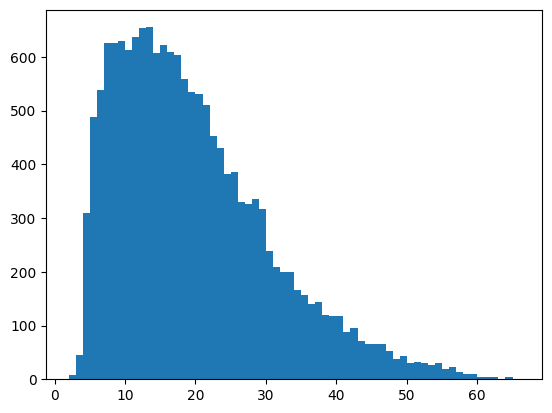

In [16]:
lengths = [len(s.split()) for s in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [17]:
# We notice that most of the tweets have less than 50 words
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
# we need to pad or truncate the sequences to a fixed length, specified by the variable "maxlen".
# This is to ensure that all sequences have the same length, which is necessary for some models to work.
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
    return padded_sequences

In [19]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [20]:
padded_train_sequences[50]

array([   2,  105,    5,    3,    6, 7419,    5,   80,  158,   79,   32,
        356,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

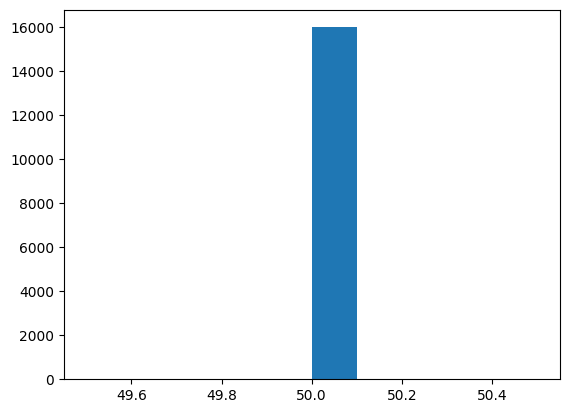

In [21]:
lengths = [len(l) for l in padded_train_sequences]
plt.hist(lengths)
plt.show()

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [22]:
classes = set(labels)
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [23]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((value,key) for key, value in class_to_index.items())

In [25]:
class_to_index

{'love': 0, 'sadness': 1, 'surprise': 2, 'fear': 3, 'anger': 4, 'joy': 5}

In [26]:
index_to_class

{0: 'love', 1: 'sadness', 2: 'surprise', 3: 'fear', 4: 'anger', 5: 'joy'}

In [27]:
labels_to_ids = lambda labels : np.array([class_to_index.get(x) for x in labels])

In [28]:
ids_to_labels = lambda ids : np.array([index_to_class.get(x) for x in ids])

In [29]:
train_labels = labels_to_ids(labels)
train_labels[50]

5

## Creating the Model

1. Creating the model
2. Compiling the model

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training the Model

1. Preparing a validation set
2. Training the model

In [32]:
val_tweets, val_labels = get_tweet(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = labels_to_ids(val_labels)

In [33]:
val_tweets[69], val_labels[69]

('i have no extra money im worried all of the time and i feel so beyond pathetic',
 1)

In [34]:
m = model.fit(
    padded_train_sequences,
    train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.3775 - loss: 1.5396 - val_accuracy: 0.6685 - val_loss: 0.9442
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7364 - loss: 0.7455 - val_accuracy: 0.7965 - val_loss: 0.6163
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8649 - loss: 0.4057 - val_accuracy: 0.8385 - val_loss: 0.4567
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9171 - loss: 0.2583 - val_accuracy: 0.8655 - val_loss: 0.4426
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9409 - loss: 0.1833 - val_accuracy: 0.8760 - val_loss: 0.4330
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9542 - loss: 0.1436 - val_accuracy: 0.8825 - val_loss: 0.4016
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9639 - loss: 0.1239 - val_accuracy: 0.8805 - val_loss: 0.4431
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9671 - loss: 0.1076 - val_a

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

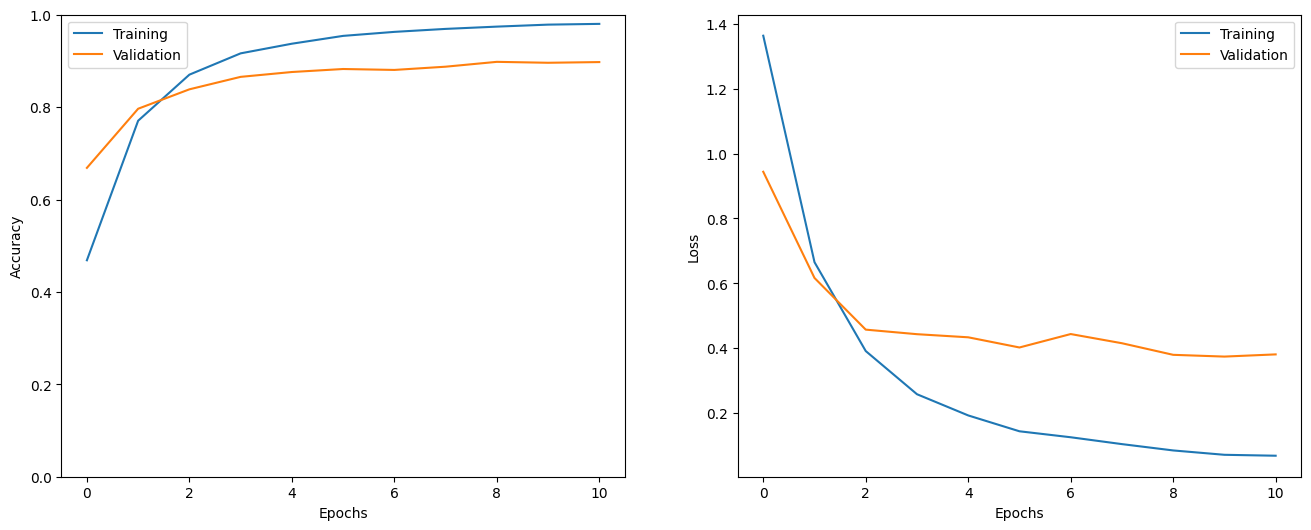

In [35]:
show_history(m)

In [36]:
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = labels_to_ids(test_labels)

In [37]:
_ = model.evaluate(test_sequences, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8921 - loss: 0.3850


In [38]:
for _ in range(5):
    i = random.randint(0, len(test_labels)-1)
    print("Tweet : ", test_tweets[i]," ==> label : ",index_to_class[test_labels[i]])
    p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
    pred_class = index_to_class[np.argmax(p).astype('uint8')]
    print("predicted label : ", pred_class)
    print("-----------------------")

Tweet :  i could adopt and what messages i could think about to help make me feel more peaceful more grateful and just happier right now  ==> label :  joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
predicted label :  joy
-----------------------
Tweet :  i love neglecting this blog but sometimes i feel for my faithful readers  ==> label :  love
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted label :  joy
-----------------------
Tweet :  i also know what it feels like to be in a relationship where you feel like a burden and too much and not worth loving or pursuing and its just  ==> label :  love
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted label :  love
-----------------------
Tweet :  i feel like they are more boring to paint than a bunch of fruit  ==> label :  sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted label :  sadness
-----------------------
Tweet :  i to feel unwelcome at her apartment certainly not  ==> label :  sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted la

In [39]:
# predictions = model.predict_classes(test_sequences)
predict_x=model.predict(test_sequences)
classes_x=np.argmax(predict_x,axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


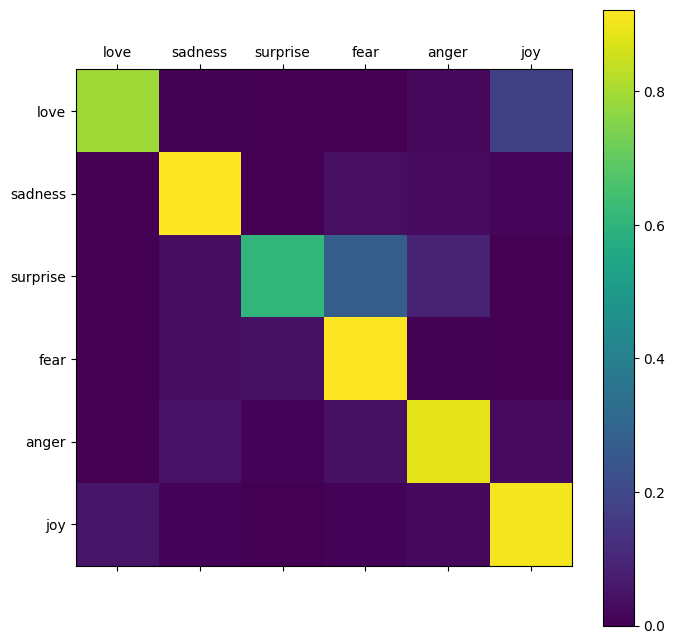

In [40]:
show_confusion_matrix(test_labels, classes_x, list(classes))